In [1]:
import os
import numpy as np
import pywt
import random
import seaborn as sns
import tensorflow as tf
from keras.layers import Add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
  Input, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, 
  Dense, Dropout, GRU, Concatenate, LayerNormalization, MultiHeadAttention, 
  Reshape, Multiply, Softmax
)
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from utils import (
  encode_labels, check_gpu_availability, plot_loss_accuracytupian, 
  evaluate_model, plot_confusion_matrixtupian, plot_tsne, 
  plot_precision_recall_curve_multiclasstupian, plot_roc_curve_multiclasstupian, 
  AdjustLearningRateCallback, denoise2,count_labels,denoise2_iterative2,AdjustLearningRateCallback
)
from utils import plot_precision_recall_curve_multiclass,plot_roc_curve_multiclass2,calculate_g_mean,plot_confusion_matrix,plot_confusion_matrix2,plot_loss_accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1DTranspose


c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.20.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
check_gpu_availability()

GPU 可用


In [3]:
datafilename1 = "C:\\Users\\Administrator\\Desktop\\database\\cinc2017denoise.npz"
data1 = np.load(datafilename1, allow_pickle=True)
X_train, y_train, X_val, y_val, X_test, y_test = data1['ecgstrain'], data1['labelstrain'], data1['ecgsval'], data1['labelsval'], data1['ecgstest'], data1['labelstest']

In [4]:
y_train = encode_labels(y_train)
y_test = encode_labels(y_test)
y_val= encode_labels(y_val)
y_train = to_categorical(y_train, num_classes=4)
y_val=to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [5]:
from tensorflow.keras.layers import Cropping1D

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Dense, BatchNormalization, Activation, Add, Multiply, GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import Model
def conv_block(x, filters, kernel_size, strides=1):
    x = Conv1D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x
def res_block(x, filters, kernel_size, pool_size=1, dropout_rate=0.1):
    shortcut = x
    x = conv_block(x, filters, kernel_size,strides=2)
    x = Dropout(dropout_rate)(x)
    x = conv_block(x, filters, kernel_size)
    x = Dropout(dropout_rate)(x)
    x = MaxPooling1D(pool_size=pool_size)(x)
    shortcut = MaxPooling1D(pool_size=2, padding='same')(shortcut)
    x = Add()([x, shortcut])
    return x

def crop_to_even(x):
    new_shape = x.shape[1]
    if new_shape % 2 != 0:
        x = Cropping1D(cropping=(1, 0))(x) 
    return x

def mask_branch(x, num_filters, kernel_size, num_pools):
    x1 = Conv1D(num_filters, kernel_size, padding='same')(x)
    x3 = Conv1D(num_filters, kernel_size, padding='same')(x1)
    print('x3', x3.shape)
    x3 = crop_to_even(x3)  
    print('x3', x3.shape)
    x4 = MaxPooling1D(pool_size=2, padding='same')(x3)
    x4 = Conv1D(num_filters, kernel_size, padding='same')(x4)
    print('x4', x4.shape)

    x5 = UpSampling1D(size=2)(x4)
    x5 = Conv1D(num_filters, kernel_size, padding='same')(x5)
    print('x5', x5.shape)
    x6 = Add()([x3, x5])
    x6 = Conv1D(num_filters, kernel_size, padding='same')(x6)
    x_prime = Conv1D(num_filters, 1, padding='same')(x6)
    x_prime = BatchNormalization()(x_prime)
    m = Activation('sigmoid')(x_prime)
    return m, x1

def trunk_branch2(x, num_filters, kernel_size):
    x1 = Conv1D(num_filters, kernel_size, padding='same')(x)
    m, x1_mask = mask_branch(x1, num_filters, kernel_size, num_pools=1)
    x2 = Conv1D(num_filters, kernel_size, padding='same')(x1)
    x_prime = Conv1D(num_filters, 1, padding='same')(x2)
    
    x_prime = Cropping1D(cropping=(1, 0))(x_prime) 
    print('x_prime',x_prime.shape)
    print('m',m.shape)
    x_corrected = Multiply()([x_prime, m])
    print('x_corrected',x_corrected.shape)
    print('x1_mask',x1_mask.shape)
    x1_mask= Cropping1D(cropping=(1, 0))(x1_mask) 
    x_out = Add()([x_corrected, x1_mask])
    t = Conv1D(num_filters, kernel_size, padding='same')(x_out)
    return t

def trunk_branch(x, num_filters, kernel_size):
    x1 = Conv1D(num_filters, kernel_size, padding='same')(x)
    m, x1_mask = mask_branch(x1, num_filters, kernel_size, num_pools=1)
    x2 = Conv1D(num_filters, kernel_size, padding='same')(x1)
    x_prime = Conv1D(num_filters, 1, padding='same')(x2)
    print('x_prime',x_prime.shape)
    print('m',m.shape)
    x_corrected = Multiply()([x_prime, m])
    x_out = Add()([x_corrected, x1_mask])

    t = Conv1D(num_filters, kernel_size, padding='same')(x_out)
    return t
def ra_block(x, num_filters, kernel_size):
    t = trunk_branch(x, num_filters, kernel_size)
    return t
def ra_block2(x, num_filters, kernel_size):
    t = trunk_branch2(x, num_filters, kernel_size)
    return t
def ra_net(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = conv_block(inputs, 16, 32)
    x_pool = MaxPooling1D(pool_size=2, padding='same')(x)
    res_output = res_block(x, 16, 32, pool_size=1, dropout_rate=0.5)
    x = Add()([x_pool, res_output])
    x = ra_block(x, 16, 32)
    print(x.shape)
    x = MaxPooling1D(pool_size=4, padding='same')(x)
    x = ra_block2(x, 32, 16)
    print(x.shape)
    x = MaxPooling1D(pool_size=4, padding='same')(x)
    x = ra_block2(x, 64, 9)
    print(x.shape)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = ra_block(x, 128, 3)
    print(x.shape)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    return model


input_shape = (4500, 1)  
num_classes = 4 
model = ra_net(input_shape, num_classes)
model.summary()


x3 (None, 2250, 16)
x3 (None, 2250, 16)
x4 (None, 1125, 16)
x5 (None, 2250, 16)
x_prime (None, 2250, 16)
m (None, 2250, 16)
(None, 2250, 16)
x3 (None, 563, 32)
x3 (None, 562, 32)
x4 (None, 281, 32)
x5 (None, 562, 32)
x_prime (None, 562, 32)
m (None, 562, 32)
x_corrected (None, 562, 32)
x1_mask (None, 563, 32)
(None, 562, 32)
x3 (None, 141, 64)
x3 (None, 140, 64)
x4 (None, 70, 64)
x5 (None, 140, 64)
x_prime (None, 140, 64)
m (None, 140, 64)
x_corrected (None, 140, 64)
x1_mask (None, 141, 64)
(None, 140, 64)
x3 (None, 70, 128)
x3 (None, 70, 128)
x4 (None, 35, 128)
x5 (None, 70, 128)
x_prime (None, 70, 128)
m (None, 70, 128)
(None, 70, 128)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 4500, 1)]    0                                            
__________________________________________

In [8]:
import tensorflow as tf

def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = 1e-8
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -tf.reduce_sum(alpha * tf.pow(1 - pt, gamma) * tf.math.log(pt)) - \
               tf.reduce_sum((1 - alpha) * tf.pow(pt, gamma) * tf.math.log(1 - pt))
        return loss
    return focal_loss_fixed


In [9]:
import tensorflow as tf

def weighted_crossentropy(weights):
    def loss(y_true, y_pred):
        # 计算未加权的交叉熵损失
        unweighted_loss = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
        # 应用类别权重
        weighted_loss = unweighted_loss * weights
        # 返回加权损失
        return weighted_loss
    return loss
class_weights = [2.0, 1.0, 1.5, 1.0] 

In [10]:
callback = AdjustLearningRateCallback(factor=0.1, patience=2, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.compile(optimizer='Adam', loss=weighted_crossentropy(class_weights), metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=128, epochs=80, validation_data=(X_val, y_val), callbacks=[callback,early_stopping])

Epoch 1/80
110/110 [==============================] - 43s 119ms/step - loss: 2.1530 - accuracy: 0.5795 - val_loss: 1.3271 - val_accuracy: 0.5924
Epoch 2/80
110/110 [==============================] - 11s 96ms/step - loss: 1.0545 - accuracy: 0.6611 - val_loss: 1.0701 - val_accuracy: 0.6578
Epoch 3/80
110/110 [==============================] - 10s 95ms/step - loss: 0.9183 - accuracy: 0.7146 - val_loss: 0.8799 - val_accuracy: 0.7406
Epoch 4/80
110/110 [==============================] - 11s 98ms/step - loss: 0.8068 - accuracy: 0.7528 - val_loss: 0.9045 - val_accuracy: 0.7161
Epoch 5/80
110/110 [==============================] - 10s 94ms/step - loss: 0.7513 - accuracy: 0.7787 - val_loss: 0.8201 - val_accuracy: 0.7619
Epoch 6/80
110/110 [==============================] - 10s 94ms/step - loss: 0.6941 - accuracy: 0.7989 - val_loss: 0.7751 - val_accuracy: 0.7782
Epoch 7/80
110/110 [==============================] - 10s 95ms/step - loss: 0.6713 - accuracy: 0.8067 - val_loss: 0.6492 - val_accuracy

In [11]:
evaluate_model(model,X_test,y_test)

Precision: 0.8071206966813241
Recall: 0.7753853618418319
F1 Score: 0.7868595007692539
Accuracy: 0.8559935639581657
Class 1 - Precision: 0.8104838709677419, Recall: 0.8854625550660793, F1 Score: 0.8463157894736841
Class 2 - Precision: 0.8691131498470948, Recall: 0.9467021985343105, F1 Score: 0.90625
Class 3 - Precision: 0.8430034129692833, Recall: 0.6693766937669376, F1 Score: 0.7462235649546827
Class 4 - Precision: 0.7058823529411765, Recall: 0.6, F1 Score: 0.6486486486486486
Class 1 Accuracy: 0.9706355591311343
Class 2 Accuracy: 0.8817377312952535
Class 3 Accuracy: 0.8648431214802896
Class 4 Accuracy: 0.994770716009654


In [12]:
y_pred_classes = np.argmax(model.predict(X_test), axis=-1)
y_test_classes = np.argmax(y_test, axis=1)

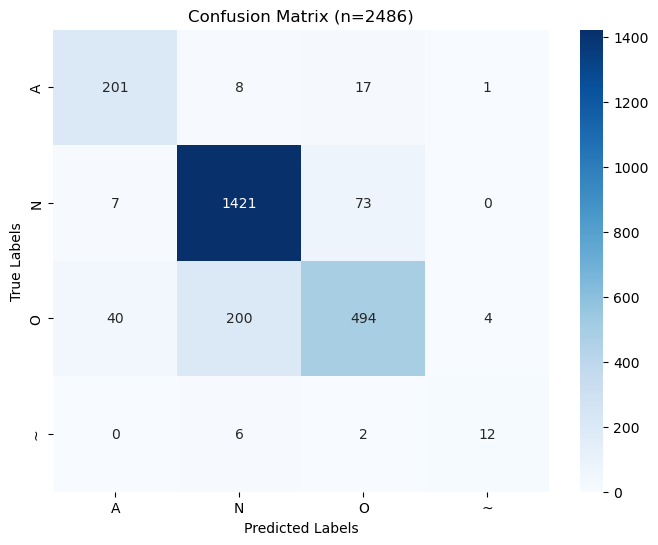

In [13]:
plot_confusion_matrix2(y_test_classes, y_pred_classes, classes=['A', 'N', 'O', '~'])